In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
# cd into directory
%cd /content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code

ValueError: mount failed

In [ ]:
# 1. imports

import os
import time

import random
import numpy as np
import pandas as pd

# data
from torch.utils.data import DataLoader
from ddi_dataset import DDI_Dataset, test_transform

# models and methods
import torch
import torch.nn as nn # to build a nn class
import torch.nn.functional as F # to use softmax
import torch.optim as optim
from torchvision import models, transforms, datasets #? need datasets?
# https://pytorch.org/vision/versions.html
# Incpt doc: https://pytorch.org/vision/stable/models/generated/torchvision.models.inception_v3.html
# Incpt code: https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py


import sklearn
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt

# versions check
print("torch version")
print(torch.__version__)
print("torch cuda version")
print(torch.version.cuda)
print("torch CuDNN version")
print(torch.backends.cudnn.version())
print("python version")
!python --version
print("numpy version")
print(np.__version__)
print("matplotlib version")
print(matplotlib.__version__)
print("sklearn version")
print(sklearn.__version__)

torch version
2.4.1+cu121
torch cuda version
12.1
torch CuDNN version
90100
python version
Python 3.10.12
numpy version
1.26.4
matplotlib version
3.7.1
sklearn version
1.5.2


In [ ]:
# 2. methods

# moving reproducibility - initalize at same random start (eg sequence of rand #s)
# to start data random, and reset model random
def reproducibility():
  # moving seeds
  # seed 1
  random_seed = 1125394389
  # seed 2
  # random_seed = 3453964320
  # seed 3
  # random_seed = 1205876402
  # seed 4
  # random_seed = 4053877640

  #specific library random # generators
  random.seed(random_seed)
  np.random.seed(random_seed)
  torch.manual_seed(random_seed) #cpu & gpu
  torch.cuda.manual_seed(random_seed) #single -gpu
  torch.cuda.manual_seed_all(random_seed) # if use multi-gpu

  # for speed up code later
  # # dataloader worker reproducibility
  # def seed_worker(worker_id):
  #     worker_seed = torch.initial_seed() % 2**32
  #     np.random.seed(worker_seed)
  #     random.seed(worker_seed)
  # g = torch.Generator()
  # g.manual_seed(0)

  # test reproducibility Generate a random number using each random number generator
  random_num = random.randint(0, 100)
  np_random_num = np.random.randint(0, 100)
  torch_random_num = torch.randint(0, 100, (1,))

  return random_num, np_random_num, torch_random_num

# calculates train loss summed over batches
def train_loop(model, train_loader, optimizer, criterion, device):
  model.train()
  train_loss_total = 0.0
  for batch in enumerate(train_loader):
    i, (paths,images,target,skin_tone) = batch
    images = images.to(device)
    target = target.to(device)

    optimizer.zero_grad()
    train_logits, train_aux_logits = model(images)

    # alternative way extract logits from output
    # train_output = model(images)
    # train_logits = train_output.logits

    train_loss = criterion(train_logits,target)
    train_loss.backward()
    optimizer.step()
    train_loss_total += train_loss.item()
  return train_loss_total

# calculates val loss summed over batches
def validate(model, val_loader, criterion, device):
  model.eval()
  val_loss_total = 0.0
  with torch.no_grad():
    for batch in enumerate(val_loader):
      i, (paths,images,target,skin_tone) = batch
      images = images.to(device)
      target = target.to(device)

      val_logits = model(images) # aux_logits !output during validation

      val_loss = criterion(val_logits, target)
      val_loss_total += val_loss.item()
  return val_loss_total

# calculates ROC
def test(model, test_loader, criterion, device):
  model.eval()

  # to calculate ROC
  test_predicted_probas_class_1_total = []
  test_targets_total = []

  # accumulate all targets and class 1 predicted prob -> roc_auc_score
  with torch.no_grad():
    for batch in enumerate(test_loader):
      i, (paths,images,target,skin_tone) = batch
      images = images.to(device)
      target = target.to(device)

      test_logits = model(images)
      test_logits_class_1 = test_logits[:,1] # need just class 1

      # softmax vs sigmoid to choose. softmax  b/c inception performs softmax and two neuron output
      # dim = 0 along first dimension. requirement of softmax method
      test_predicted_probas_class_1 = F.softmax(test_logits_class_1, dim=0)
      # add batch probs of class 1 to total probs as single elements. vs append. to combine all into one
      test_predicted_probas_class_1_total.extend(test_predicted_probas_class_1.cpu().numpy())
      # add batch targets of class 1 to total probs as single elements. vs append. to combine all into one
      test_targets_total.extend(target.cpu().numpy())

  roc_auc = roc_auc_score(test_targets_total, test_predicted_probas_class_1_total)
  return roc_auc

# create a train sample with pct of l2 list & 100% l1 list
# samples from each list w/ replacement
def train_sample_with_pct_single_tone(l1, l2, percent_l2):
  samples_l1 = random.choices(l1, k=len(l1)) #list1 sample size
  samples_l2 = random.choices(l2, k=int(len(l2)*percent_l2)) #list2 sample size
  combined_samples = samples_l1 + samples_l2
  return combined_samples

In [ ]:
# 3. Overall reproducbility
# 3a. moving reproducibility for data
# ? place right before data?
reproducibility()

# 3b. global reproducibility

# 3bi. set cuDNN convolution benchmarking false. use default conv alg. No optimize by find best alg for given conv filters, size parameters etc.
torch.backends.cudnn.benchmark = False

# 3bii. used just in case rand algs ! specified in documentation
# use deterministic algorithm counterparts (including cuDNN counterparts)
torch.use_deterministic_algorithms(mode=True)

# 3biii. set cublas workspace size
# check cuda version if >= 10.2 needs set workspace constant
if torch.cuda.is_available():
    print("PyTorch has GPU support.")
    print("CUDA version:", torch.version.cuda)
    print("GPU count:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.get_device_name(0))  # Change 0 to the GPU index you want to check if multiple GPUs are available
else:
    print("PyTorch does not have GPU support on this system.")

# set cuda workspace size constant for each stream
# set if multiple streams
# set if CUDA vs >10.2. b/c some CUDA operations non-deterministic if workspace not set (?or if workspace variable)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
print(os.environ["CUBLAS_WORKSPACE_CONFIG"])

PyTorch does not have GPU support on this system.
:4096:8


In [ ]:
# 4. Input data
# obtain data through DDI user-defined classed
# performs image test transforms to prepare for inception
# 656 instances
dataset = DDI_Dataset("DDI", transform=test_transform)

In [ ]:
# 5. Fair data base: Equal samples in tone [56,12,34] and ml/bn [1,0]
#  207 samples per tone. 48ml / 159bn

# break up into three tones
# 56,12,34 (207,208,241 instances)
# type: <class 'torch.utils.data.dataset.Subset'>
tone_56 = dataset.subset(skin_tone=[56])
# tone_34 = dataset.subset(skin_tone=[34])
tone_12 = dataset.subset(skin_tone=[12])

# break up into six (tone, ml/bn) groups
# 56-1,56-0,12-1,12-0,34-1,34-0 (48,159,49,159,74,167 instances)
# type: python list
tone_56_ml_1 = [tup for tup in tone_56 if tup[2] == 1]
tone_56_ml_0 = [tup for tup in tone_56 if tup[2] == 0]
tone_12_ml_1 = [tup for tup in tone_12 if tup[2] == 1]
tone_12_ml_0 = [tup for tup in tone_12 if tup[2] == 0]
# tone_34_ml_1 = [tup for tup in tone_34 if tup[2] == 1]
# tone_34_ml_0 = [tup for tup in tone_34 if tup[2] == 0]

# reduce to 207 samples per tone and 48ml/159bn class proportion w/i tone
# 56-1,56-0,12-1,12-0,34-1,34-0 (48,159,48,159,48,159 instances)
# type: python list
# T: check if sample performs shuffle and slice, shuffle so no learn order of data
tone_56_ml_1_base = random.sample(tone_56_ml_1,k=48)
tone_56_ml_0_base = random.sample(tone_56_ml_0,k=159)
tone_12_ml_1_base = random.sample(tone_12_ml_1,k=48)
tone_12_ml_0_base = random.sample(tone_12_ml_0,k=159)
# tone_34_ml_1_base = random.sample(tone_34_ml_1,k=48)
# tone_34_ml_0_base = random.sample(tone_34_ml_0,k=159)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# 6. Data exploration & visualization

# see counts in four areas
# ? distribution in four areas?
  # group instances into four areas?

# obtain data
metadata = pd.read_csv('DDI/ddi_metadata.csv')

# separate data into tones
tone_56_metadata = metadata[metadata['skin_tone']==56]
tone_12_metadata = metadata[metadata['skin_tone']==12]


# # *******************************************
# # See first values
print(tone_56_metadata.head(5))
print(tone_12_metadata.head(5))


# # 1
# # condition intersection of 56 U 12
# # value counts of diseases in 56 U 12

# # 2
# # condition unique to 56 in 56 U 12
# # value count of conditions unique to 56

# # 3
# # condition unique to 12 in 56 U 12
# # value count of conditions unique to 12

# # See first values
# # print(tone_56_metadata.head(5))
# # print(tone_12_metadata.head(5))
# # print(tone_34_metadata.head(5))

# # # See unique disease in each tone (53,35,50)
# # print(tone_56_metadata['disease'].nunique())
# # print(tone_12_metadata['disease'].nunique())
# # print(tone_34_metadata['disease'].nunique())

# # # disease counts for each tone -> series
# tone_56_counts = tone_56_metadata['disease'].value_counts()
# tone_12_counts = tone_12_metadata['disease'].value_counts()

# print(tone_56_counts)
# print(tone_12_counts)



# # print(tone_56_counts)

# # # extract disease text indices for each tone
# tone_56_unique_disease = tone_56_counts.index
# tone_12_unique_disease = tone_12_counts.index

# # print(tone_56_unique_disease)

# # convert to series to use its set functions
# # set seems to reorganize index unsure why same size, but first few look different
# tone_56_unique_disease_set = set(tone_56_unique_disease)
# tone_12_unique_disease_set = set(tone_12_unique_disease)
# # tone_34_unique_disease_set = set(tone_12_unique_disease)

# # # test quick way intersect
# tones_56_disease_intersect_12  = tone_56_unique_disease_set.intersection(tone_12_unique_disease_set)
# # print("Intersection of 12 & 56 Count")
# # print(len(tones_56_disease_intersect_12))
# # tones_12_disease_intersect_56  = tone_12_unique_disease_set.intersection(tone_56_unique_disease_set)

# # Convert intersection to pandas Series
# tones_56_disease_intersect_12_series = pd.Series(list(tones_56_disease_intersect_12))
# # Now can use value_counts()
# # print("56 12 Intersection Value Counts")
# # print(tones_56_disease_intersect_12_series.value_counts())

# # test set differences
# # 56 unique to self. 56-12 set notation.
# tone_56_unique_from_12 =  tone_56_unique_disease_set.difference(tone_12_unique_disease_set)
# # print("Unique 56 From 12 Count")
# # print(len(tone_56_unique_from_12))

# # Convert convert unique 56 to pandas Series
# tone_56_unique_from_12_series = pd.Series(list(tone_56_unique_from_12))
# # Now can use value_counts()
# # print("56 Unique from 12 Value Counts")
# # print(tone_56_unique_from_12_series.value_counts())



# # 12 unique to self. 12-56 set notation.
# tone_12_unique_from_56 =  tone_12_unique_disease_set.difference(tone_56_unique_disease_set)
# # print("Unique 12 From 56 Count")
# # print(len(tone_12_unique_from_56))

# # # test two-step intersect

# # # convert to list or series if need

# # # print



# # # balance disease in each tone
# #   # read paper
# #   #(remove)


# # all_tone_intersect =tone_56_unique_disease_set.intersection(tone_12_unique_disease_set,tone_34_unique_disease_set)
# # all_tone_union = tone_56_unique_disease_set.union(tone_12_unique_disease_set,tone_34_unique_disease_set)
# # *******************************************

   Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
0           0       1  000001.png         56       True   
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
5           5       6  000006.png         56       True   

                           disease  
0                 melanoma-in-situ  
1                 melanoma-in-situ  
2                mycosis-fungoides  
3  squamous-cell-carcinoma-in-situ  
5          squamous-cell-carcinoma  
    Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
4            4       5  000005.png         12       True   
36          36      37  000037.png         12       True   
37          37      38  000038.png         12       True   
38          38      39  000039.png         12       True   
39          39      40  000040.png         12       True   

                                    disease  
4               

In [ ]:
print(type(tone_56_metadata))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
set_56 = set(tone_56_metadata['disease'])
len(set_56)

53

In [ ]:
# 7. Train val test split slices
# IMPORTANT: Make sure no leaks, train/val/test overlap. Solved by defining train & val end. Leaving out train beginning.
# pct across six groups
# slicing

# % of training
train_pct = 0.6
val_pct = 0.2
test_pct = 0.2

# train % of single tone for now
# cut off points for train/val/test
train_end_tone_56_ml_1 = int(len(tone_56_ml_1_base)*train_pct)
val_end_tone_56_ml_1 = int(len(tone_56_ml_1_base)*(train_pct+val_pct))

train_end_tone_56_ml_0 = int(len(tone_56_ml_0_base)*train_pct)
val_end_tone_56_ml_0 = int(len(tone_56_ml_0_base)*(train_pct+val_pct))

train_end_tone_12_ml_1 = int(len(tone_12_ml_1_base)*train_pct)
val_end_tone_12_ml_1 = int(len(tone_12_ml_1_base)*(train_pct+val_pct))

train_end_tone_12_ml_0 = int(len(tone_12_ml_0_base)*train_pct)
val_end_tone_12_ml_0 = int(len(tone_12_ml_0_base)*(train_pct+val_pct))

# train_end_tone_34_ml_1 = int(len(tone_34_ml_1_base)*train_pct)
# val_end_tone_34_ml_1 = int(len(tone_34_ml_1_base)*(train_pct+val_pct))

# train_end_tone_34_ml_0 = int(len(tone_34_ml_0_base)*train_pct)
# val_end_tone_34_ml_0 = int(len(tone_34_ml_0_base)*(train_pct+val_pct))

# Slice at cut points
#train splits across 6
train_set_56_ml_1 = tone_56_ml_1_base[:train_end_tone_56_ml_1]
train_set_56_ml_0 = tone_56_ml_0_base[:train_end_tone_56_ml_0]
train_set_12_ml_1 = tone_12_ml_1_base[:train_end_tone_12_ml_1]
train_set_12_ml_0 = tone_12_ml_0_base[:train_end_tone_12_ml_0]
# train_set_34_ml_1 = tone_34_ml_1_base[:train_end_tone_34_ml_1]
# train_set_34_ml_0 = tone_34_ml_0_base[:train_end_tone_34_ml_0]
#val splits across 6
val_set_56_ml_1 = tone_56_ml_1_base[train_end_tone_56_ml_1:val_end_tone_56_ml_1]
val_set_56_ml_0 = tone_56_ml_0_base[train_end_tone_56_ml_0:val_end_tone_56_ml_0]
val_set_12_ml_1 = tone_12_ml_1_base[train_end_tone_12_ml_1:val_end_tone_12_ml_1]
val_set_12_ml_0 = tone_12_ml_0_base[train_end_tone_12_ml_0:val_end_tone_12_ml_0]
# val_set_34_ml_1 = tone_34_ml_1_base[train_end_tone_34_ml_1:val_end_tone_34_ml_1]
# val_set_34_ml_0 = tone_34_ml_0_base[train_end_tone_34_ml_0:val_end_tone_34_ml_0]
#test splits across 6
test_set_56_ml_1 = tone_56_ml_1_base[val_end_tone_56_ml_1:]
test_set_56_ml_0 = tone_56_ml_0_base[val_end_tone_56_ml_0:]
test_set_12_ml_1 = tone_12_ml_1_base[val_end_tone_12_ml_1:]
test_set_12_ml_0 = tone_12_ml_0_base[val_end_tone_12_ml_0:]
# test_set_34_ml_1 = tone_34_ml_1_base[val_end_tone_34_ml_1:]
# test_set_34_ml_0 = tone_34_ml_0_base[val_end_tone_34_ml_0:]

In [ ]:
# 8. Train val test grouping
# Train: group w/ % of 1 tone, Val: group all, Test: group by tone

# 7.1 train: group w/ train % of one tone, 100% other 2 tones
# group into three tones
train_set_56 = train_set_56_ml_1 + train_set_56_ml_0
train_set_12 = train_set_12_ml_1 + train_set_12_ml_0
# train_set_34 = train_set_34_ml_1 + train_set_34_ml_0

# train group: matrix of train samples
# sample shuffles so no learn order
sample_matrix = np.empty((200,2), dtype=object)
# create 10 groups for each percentage level
for i in range(200):
  for j in range(2):
    # percent_l2 = j * 0.10 #0%, 10%.....100%
    #sample 0% for 1st col, 100% for 2nd col
    if j == 0:
      percent_l2 = 0
    else:
      percent_l2 = 1

    sample_matrix[i,j] = train_sample_with_pct_single_tone(train_set_12,train_set_56,percent_l2)
    # order for reproducibility: train_set_12,train_set_56,percent_l3

# 7.2 val group: group all
val_set = (val_set_56_ml_1 + val_set_56_ml_0 +
       val_set_12_ml_1 + val_set_12_ml_0)
      #  val_set_34_ml_1 + val_set_34_ml_0)
# shuffle so not learn class ordering during epoch
random.shuffle(val_set)


# 7.3 testing groups for three separate tones
test_set_56 = test_set_56_ml_1 + test_set_56_ml_0
test_set_12 = test_set_12_ml_1 + test_set_12_ml_0
# test_set_34 = test_set_34_ml_1 + test_set_34_ml_0

# 7.4 roc matrices for plotting
# testing ROC result matrices on three tones
ROC_54_Samples = np.zeros_like(sample_matrix)
ROC_12_Samples = np.zeros_like(sample_matrix)
# ROC_34_Samples = np.zeros_like(sample_matrix)


In [ ]:
type(sample_matrix[0,0])
type(val_set)
type(test_set_56)
type(test_set_12)

list

In [ ]:
# 9 Model/Module exploration

# model initialize or reset
# ?load the weights with dictionary and state?
model_exp = models.inception_v3(weights='IMAGENET1K_V1')

# replace fc w/ 2
# ?replaces fc bias w/ new bias too?
num_in_ftrs_fc = model_exp.fc.in_features
num_out_ftrs_fc = model_exp.fc.out_features
print(model_exp)
model_exp.fc = nn.Linear(num_in_ftrs_fc,2)



# Iterate over all submodules
for name, module in model_exp.named_modules():
    print(name)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
print(num_in_ftrs_fc)
print(num_out_ftrs_fc)

2048
1000


In [ ]:
print(model)

In [ ]:
# Disregard: Train loop testing
# reproducibility()

# # no workers
# val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# # no workers
# test_loader_56 = DataLoader(test_set_56, batch_size=32, shuffle=False)
# # no workers
# test_loader_12 = DataLoader(test_set_12, batch_size=32, shuffle=False)
# # no workers
# test_loader_34 = DataLoader(test_set_34, batch_size=32, shuffle=False)

# # no workers
# train_loader = DataLoader(sample_matrix[0,0], batch_size=32, shuffle=True)

# # model initialize or reset
# # ?load the weights with dictionary and state?
# model = models.inception_v3(weights='IMAGENET1K_V1')

# # replace fc w/ 2
# # ?replaces fc bias w/ new bias too?
# num_in_ftrs_fc = model.fc.in_features
# model.fc = nn.Linear(num_in_ftrs_fc,2)

# # 1 Freeze just convolution
# # # Layers to freeze
# # # freeze early layers
# # layers_to_freeze = [
# #     'Conv2d_1a_3x3',
# #     'Conv2d_2a_3x3',
# #     'Conv2d_2b_3x3',
# #     'Conv2d_3b_1x1',
# #     'Conv2d_4a_3x3']
# # # Freeze specified layers
# # for name, param in model.named_parameters():
# #     if any(layer in name for layer in layers_to_freeze):
# #         param.requires_grad = False

# # 2 Freeze all except FC
# for param in model.parameters():
#   param.requires_grad = False
# for param in model.fc.parameters():
#   param.requires_grad = True

# # Use GPU if choose & available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model to cpu or gpu
# model = model.to(device)

# # loss function
# criterion = nn.CrossEntropyLoss()

# # optimizer
# learning_rate = 5e-2
# decay = 1e-4

# # # pass only unfrozen layers to optimizer to learn/update
# # unfrozen_parameters = [param for name, param in model.named_parameters() if not any(layer in name for layer in layers_to_freeze)]
# # optimizer = optim.Adam(unfrozen_parameters, lr=learning_rate, weight_decay=decay)
# optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay = decay)#weight update equation <<learns only fc layers

# # 2. TRAIN/VAL MODEL EARLYSTOPPING
# # train & val
# # reproducibility()

# # Initialize variables to track the best validation loss and early stopping
# best_val_loss = float('inf')
# patience = 5  # Number of epochs with increasing val loss before stopping
# count = 0  # Counter for patience

# num_epochs = 1
# epochs = range(1, num_epochs+1,1)
# for epoch in range(1, num_epochs+1,1):
#   train_loss_total = train_loop(model, train_loader, optimizer, criterion, device)
#   val_loss_total = validate(model, val_loader, criterion, device)

#   avg_train_loss = train_loss_total / len(train_loader)
#   avg_val_loss = val_loss_total / len(val_loader)

#   print(f"Epoch [{epoch}/{num_epochs}] -  Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

#   # Early Stopping Check
#   if avg_val_loss < best_val_loss:
#       best_val_loss = avg_val_loss
#       count = 0
#   else:
#       count += 1
#       if count >= patience:
#           print("Validation loss is increasing. Early stopping...")
#           break

#   # test 56
#   auroc_56 = test(model, test_loader_56, criterion, device)
#   # test 12
#   auroc_12 = test(model, test_loader_12, criterion, device)
#   # test 34
#   auroc_34 = test(model, test_loader_34, criterion, device)

In [ ]:
 # 10 Train Val -> Test -> ROC-AUC

  # steps in double loop
  # 1. Initialize inception model
  # 2. Train/Val early stopping & patience
  # 3. Test model 3 separate tones

# QUANTIFY BIAS FOR EACH OF 111 samples
iteration = 0
start_time = time.time()
for i in range(sample_matrix.shape[0]):
  for j in range(sample_matrix.shape[1]):
    # 0. ITERATION FOR PROGRESS BAR
    iteration = iteration + 1
    print(f"Iteration: {iteration}")

    # 1. INITIALIZE/RESET MODEL/TRAIN PATH & INPUT NEXT DATA
    reproducibility()

    # no workers
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

    # no workers
    test_loader_56 = DataLoader(test_set_56, batch_size=32, shuffle=False)
    # no workers
    test_loader_12 = DataLoader(test_set_12, batch_size=32, shuffle=False)
    # no workers
    # test_loader_34 = DataLoader(test_set_34, batch_size=32, shuffle=False)

    # no workers
    train_loader = DataLoader(sample_matrix[i,j], batch_size=32, shuffle=True)

    # model initialize or reset
    # ?load the weights with dictionary and state?
    model = models.inception_v3(weights='IMAGENET1K_V1')

    # replace fc w/ 2
    # ?replaces fc bias w/ new bias too?
    num_in_ftrs_fc = model.fc.in_features
    model.fc = nn.Linear(num_in_ftrs_fc,2)

    # 1 Freeze just convolution
    # # Layers to freeze
    # # freeze early layers
    # layers_to_freeze = [
    #     'Conv2d_1a_3x3',
    #     'Conv2d_2a_3x3',
    #     'Conv2d_2b_3x3',
    #     'Conv2d_3b_1x1',
    #     'Conv2d_4a_3x3']
    # # Freeze specified layers
    # for name, param in model.named_parameters():
    #     if any(layer in name for layer in layers_to_freeze):
    #         param.requires_grad = False

    # 2 Freeze all except FC
    for param in model.parameters():
      param.requires_grad = False
    for param in model.fc.parameters():
      param.requires_grad = True

    # Use GPU if choose & available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Model to cpu or gpu
    model = model.to(device)

    # loss function
    criterion = nn.CrossEntropyLoss()

    # optimizer settings
    learning_rate = 5e-2
    decay = 1e-4

    # # pass only unfrozen layers to optimizer to learn/update
    # unfrozen_parameters = [param for name, param in model.named_parameters() if not any(layer in name for layer in layers_to_freeze)]
    # optimizer = optim.Adam(unfrozen_parameters, lr=learning_rate, weight_decay=decay)
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay = decay)#weight update equation <<learns only fc layers

    # 2. TRAIN/VAL MODEL EARLYSTOPPING
    # train & val
    # reproducibility()

    # Initialize variables to track the best validation loss and early stopping
    best_val_loss = float('inf')
    patience = 5  # Number of epochs with increasing val loss before stopping
    count = 0  # Counter for patience

    # Train w/ early stopping
    num_epochs = 20
    epochs = range(1, num_epochs+1,1)
    for epoch in range(1, num_epochs+1,1):
      train_loss_total = train_loop(model, train_loader, optimizer, criterion, device)
      val_loss_total = validate(model, val_loader, criterion, device)

      avg_train_loss = train_loss_total / len(train_loader)
      avg_val_loss = val_loss_total / len(val_loader)

      print(f"Epoch [{epoch}/{num_epochs}] -  Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

      # Early Stopping Check
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          # save best model so far
          torch.save(model.state_dict(), 'best_model_state.pth')
          count = 0
      else:
          count += 1
          if count >= patience:
              print("Validation loss is increasing. Early stopping...")
              break

    # load best model found for this sample data at %
    model.load_state_dict(torch.load('best_model_state.pth'))

    # 3. TEST MODEL
    # test 56 roc
    auroc_56 = test(model, test_loader_56, criterion, device)
    # test 12 roc
    auroc_12 = test(model, test_loader_12, criterion, device)
    # test 34 roc
    # auroc_34 = test(model, test_loader_34, criterion, device)

    # save roc scores into two matrices
    ROC_54_Samples[i,j] = auroc_56
    print(f"ROC_56:{ROC_54_Samples[i,j]}")
    ROC_12_Samples[i,j] = auroc_12
    print(f"ROC_12:{ROC_12_Samples[i,j]}")
    # ROC_34_Samples[i,j] = auroc_34
    # print(f"ROC_34:{ROC_34_Samples[i,j]}")

    # 4. TIMING & FOR LOOP ITERATION
    current_time = time.time()
    elapsed_time = current_time - start_time
    print(f"time after iteration {iteration}: {elapsed_time:0.2f} seconds")

Iteration: 1


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 103MB/s] 


KeyboardInterrupt: 

In [ ]:
# 11. Save ROC output numpy matrices
np.save('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d5612_ROC_56_SampleMatrix200by2_TrnOnlyFcLyrs_56Asc200by2Samples_L4gpu_Seed1125394389.npy', ROC_54_Samples)
np.save('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d5612_ROC_12_SampleMatrix200by2_TrnOnlyFcLyrs_12Asc200by2Samples_A100_Seed1125394389.npy.npy', ROC_12_Samples)
# np.save('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d_ROC_34_SampleMatrix50by11_TrnOnlyFcLyrs_34Asc50by11Samples_A100_Seed1125394389.npy', ROC_34_Samples)

In [ ]:
# 12. Load ROC output numpy matrices for quick plotting
# 12 ascend
ROC_54_Samples=np.load('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d5612_ROC_56_SampleMatrix200by2_TrnOnlyFcLyrs_12Asc200by2Samples_A100_Seed1125394389.npy',allow_pickle=True)
ROC_12_Samples=np.load('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d5612_ROC_12_SampleMatrix200by2_TrnOnlyFcLyrs_12Asc200by2Samples_A100_Seed1125394389.npy',allow_pickle=True)
# 56 ascend

# ROC_34_Samples=np.load('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d_ROC_34_SampleMatrix50by11_TrnOnlyFcLyrs_34Asc50by11Samples_A100_Seed1125394389.npy',allow_pickle=True)

ValueError: x and y must have same first dimension, but have shapes (11,) and (2,)

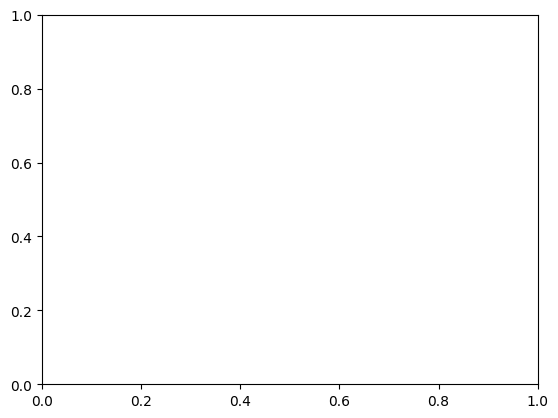

In [ ]:
# 13. Plot all tones
seed = 123456789
random.seed(seed)

x = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # x-coordinates of % points

# ROC_54_Samples = np.zeros_like(sample_matrix)
# ROC_12_Samples = np.zeros_like(sample_matrix)
# ROC_34_Samples = np.zeros_like(sample_matrix)

ROC_54_Samples_to_float64 = ROC_54_Samples.astype(float)  # Convert to float
ROC_12_Samples_to_float64 = ROC_12_Samples.astype(float)  # Convert to float
# ROC_34_Samples_to_float64 = ROC_34_Samples.astype(float)  # Convert to float

# Mean values along columns
mean_values_54 = np.mean(ROC_54_Samples_to_float64,axis=0)
mean_values_12 = np.mean(ROC_12_Samples_to_float64,axis=0)
# mean_values_34 = np.mean(ROC_34_Samples_to_float64,axis=0)

# Standard deviations along columns
standard_deviations_54 = np.std(ROC_54_Samples_to_float64,axis=0)
standard_deviations_12 = np.std(ROC_12_Samples_to_float64,axis=0)
# standard_deviations_34 = np.std(ROC_34_Samples_to_float64,axis=0)

# create figure and axis
fig = plt.figure()

# Calc 10 lower standard deviation points per line
lower_standard_deviations_54 = mean_values_54 - standard_deviations_54
lower_standard_deviations_12 = mean_values_12 - standard_deviations_12
# lower_standard_deviations_34 = mean_values_34 - standard_deviations_34

# Calc 10 upper standard deviation points per line
upper_standard_deviations_54 = mean_values_54 + standard_deviations_54
upper_standard_deviations_12 = mean_values_12 + standard_deviations_12
# upper_standard_deviations_34 = mean_values_34 + standard_deviations_34

# Plot y1 mean values line
plt.plot(x, mean_values_54,color='blue',label='56 mean',marker='o')
# Plot y2 mean values line
plt.plot(x, mean_values_12,color='red',label='12 mean',marker='o')
# Plot y3 mean values line
# plt.plot(x, mean_values_34,color='lightgreen',label='34 mean',marker='o')

# Fill between y1 means +/- standard deviation. select color and transparency.
plt.fill_between(x, lower_standard_deviations_54,upper_standard_deviations_54, color='blue',alpha=0.1,edgecolor='darkblue')
# Fill between y2 means +/- standard deviation. select color and transparency.
plt.fill_between(x, lower_standard_deviations_12,upper_standard_deviations_12, color='red',alpha=0.1,edgecolor='darkred')
# Fill between y3 means +/- standard deviation. select color and transparency.
# plt.fill_between(x, lower_standard_deviations_34,upper_standard_deviations_34, color='lightgreen',alpha=0.1,edgecolor='darkgreen')

# Create labels
plt.xlabel('12 pct ascending')
plt.ylabel('ROC-AUC')
plt.title('Sampling Bias Quantification')
plt.legend()
plt.show()

In [ ]:
# 14. Plot dark
# Plot y1 mean values line
plt.plot(x, mean_values_54,color='blue',label='56 mean',marker='o')
# Fill between y1 means +/- standard deviation. select color and transparency.
plt.fill_between(x, lower_standard_deviations_54,upper_standard_deviations_54, color='blue',alpha=0.1,edgecolor='darkblue')

In [ ]:
# # 15. Plot medium
# # Plot y3 mean values line
# plt.plot(x, mean_values_34,color='lightgreen',label='34 mean',marker='o')
# # Fill between y3 means +/- standard deviation. select color and transparency.
# plt.fill_between(x, lower_standard_deviations_34,upper_standard_deviations_34, color='lightgreen',alpha=0.1,edgecolor='darkgreen')

In [ ]:
# 16. Plot light
# Plot y2 mean values line
plt.plot(x, mean_values_12,color='red',label='12 mean',marker='o')
# Fill between y2 means +/- standard deviation. select color and transparency.
plt.fill_between(x, lower_standard_deviations_12,upper_standard_deviations_12, color='red',alpha=0.1,edgecolor='darkred')

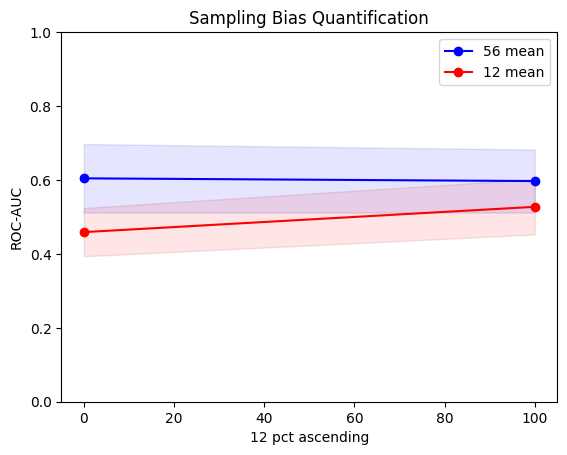

In [ ]:
# 17. Plot all tones just 0% and 100% on x - axis
seed = 123456789
random.seed(seed)

x = [0, 100]  # x-coordinates of % points

# ROC_54_Samples = np.zeros_like(sample_matrix)
# ROC_12_Samples = np.zeros_like(sample_matrix)
# ROC_34_Samples = np.zeros_like(sample_matrix)

ROC_54_Samples_to_float64 = ROC_54_Samples.astype(float)  # Convert to float
ROC_12_Samples_to_float64 = ROC_12_Samples.astype(float)  # Convert to float
# ROC_34_Samples_to_float64 = ROC_34_Samples.astype(float)  # Convert to float

# Mean values along columns
mean_values_54 = np.mean(ROC_54_Samples_to_float64,axis=0)
mean_values_12 = np.mean(ROC_12_Samples_to_float64,axis=0)
# mean_values_34 = np.mean(ROC_34_Samples_to_float64,axis=0)

# Standard deviations along columns
standard_deviations_54 = np.std(ROC_54_Samples_to_float64,axis=0, ddof=0)
standard_deviations_12 = np.std(ROC_12_Samples_to_float64,axis=0, ddof=0)
# standard_deviations_34 = np.std(ROC_34_Samples_to_float64,axis=0)

# create figure and axis
fig = plt.figure()

# Calc 10 lower standard deviation points per line
lower_standard_deviations_54 = mean_values_54 - standard_deviations_54
lower_standard_deviations_12 = mean_values_12 - standard_deviations_12
# lower_standard_deviations_34 = mean_values_34 - standard_deviations_34

# Calc 10 upper standard deviation points per line
upper_standard_deviations_54 = mean_values_54 + standard_deviations_54
upper_standard_deviations_12 = mean_values_12 + standard_deviations_12
# upper_standard_deviations_34 = mean_values_34 + standard_deviations_34

# Set y-axis limits from 0 to 1
plt.ylim(0, 1)

# Plot y1 mean values line
plt.plot(x, mean_values_54,color='blue',label='56 mean',marker='o')
# Plot y2 mean values line
plt.plot(x, mean_values_12,color='red',label='12 mean',marker='o')
# Plot y3 mean values line
# plt.plot(x, mean_values_34,color='lightgreen',label='34 mean',marker='o')

# Fill between y1 means +/- standard deviation. select color and transparency.
plt.fill_between(x, lower_standard_deviations_54,upper_standard_deviations_54, color='blue',alpha=0.1,edgecolor='darkblue')
# Fill between y2 means +/- standard deviation. select color and transparency.
plt.fill_between(x, lower_standard_deviations_12,upper_standard_deviations_12, color='red',alpha=0.1,edgecolor='darkred')
# Fill between y3 means +/- standard deviation. select color and transparency.
# plt.fill_between(x, lower_standard_deviations_34,upper_standard_deviations_34, color='lightgreen',alpha=0.1,edgecolor='darkgreen')

# Create labels
plt.xlabel('12 pct ascending')
plt.ylabel('ROC-AUC')
plt.title('Sampling Bias Quantification')
plt.legend()
plt.show()



In [ ]:
print(ROC_12_Samples)

In [ ]:

var_values_54 = np.var(ROC_54_Samples_to_float64,axis=0,ddof=1)
var_values_12 = np.var(ROC_12_Samples_to_float64,axis=0,ddof=1)
print(var_values_54)
print(var_values_12)
print(standard_deviations_54)
print(standard_deviations_12)

[0.00865205 0.00731158]
[0.00428622 0.0056196 ]
[0.09278356 0.08529372]
[0.06530535 0.07477636]


In [ ]:
print(mean_values_12.shape)
print(standard_deviations_54.shape)
print(mean_values_12)
print(standard_deviations_12)

(2,)
(2,)
[0.458875   0.52732813]
[0.06530535 0.07477636]


In [ ]:
print(mean_values_54)

[0.604375   0.59704688]


In [ ]:
print(mean_values_12-standard_deviations_12)

[0.39356965 0.45255177]


TypeError: unsupported operand type(s) for ^: 'float' and 'int'

In [ ]:
# 18. In testing: Save the trained model
model_path = '/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/DDI_model.pth'
torch.save(model.state_dict(), model_path)

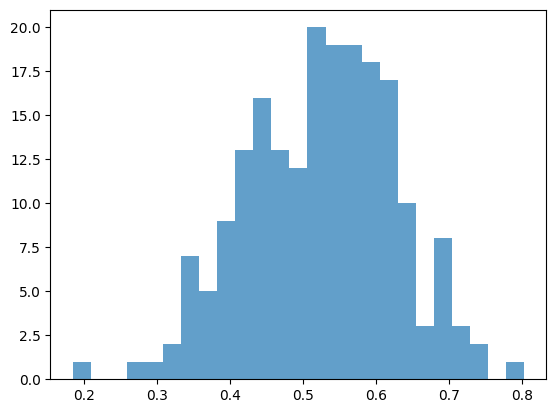

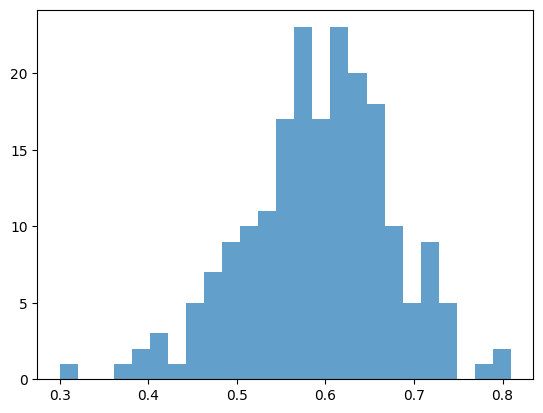

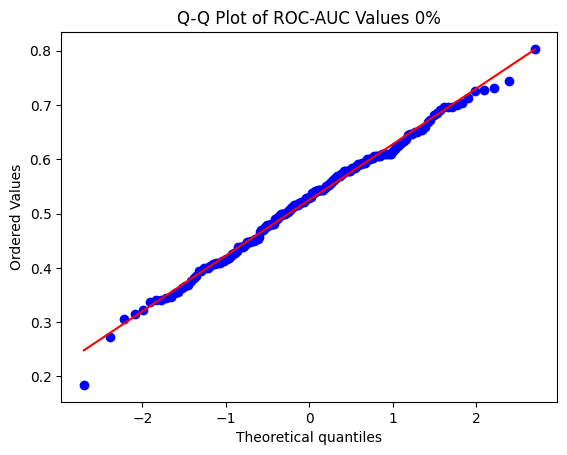

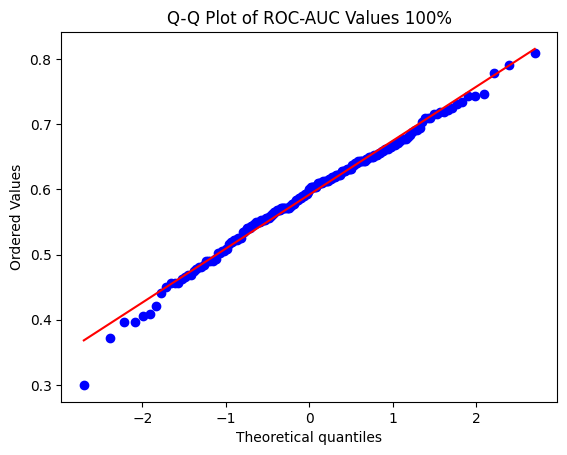

Shapiro-Wilk Test: W-statistic= 0.9949223412075014 , p-value= 0.7385809959353431
Shapiro-Wilk Test: W-statistic= 0.9917682511875483 , p-value= 0.3182223265237497
anderson 0pct
Anderson-Darling Statistic: 0.3580093316838031
At significance level 15.0%, critical value is 0.565.
Statistically, the data are normally distributed at 15.0% significance level.
At significance level 10.0%, critical value is 0.644.
Statistically, the data are normally distributed at 10.0% significance level.
At significance level 5.0%, critical value is 0.772.
Statistically, the data are normally distributed at 5.0% significance level.
At significance level 2.5%, critical value is 0.901.
Statistically, the data are normally distributed at 2.5% significance level.
At significance level 1.0%, critical value is 1.071.
Statistically, the data are normally distributed at 1.0% significance level.
anderson 100pct
Anderson-Darling Statistic: 0.45795424123892303
At significance level 15.0%, critical value is 0.565.
Stati

In [ ]:
# 19. Statistical significance
# note: augmentation <-check original paper and the latest paper
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors

# 1. T-test Two Sample 0%/100%
# data .npy names
# 12 ASC 12 PLOT
# 6d_ROC_12_SampleMatrix50by11_TrnOnlyFcLyrs_12Asc50by11Samples_A100_Seed1125394389
# 6d_ROC_56_SampleMatrix50by11_TrnOnlyFcLyrs_12Asc50by11Samples_A100_Seed1125394389
# ROC_12_SampleMatrix10by11_TrnOnlyFcLyrs_12Asc10by11Samples_V100_Seed1205876402
# ROC_12_SampleMatrix10by11_TrnOnlyFcLyrs_12Asc10by11Samples_A100_Seed3453964320
# 56 ASC 56 PLOT
# 6d5612_ROC_56_SampleMatrix50by11_TrnOnlyFcLyrs_56Asc50by11Samples_A100_Seed1125394389


# 16.1 Check type of stat hypoth test (current check-t test)
# 16.1.1 normality
# 6d_ROC_12_SampleMatrix50by11_TrnOnlyFcLyrs_12Asc50by11Samples_A100_Seed1125394389
# 6d_ROC_56_SampleMatrix10by11_TrnOnlyFcLyrs_12Asc10by11Samples_A100_Seed1125394389
# ROC_12_SampleMatrix10by11_TrnOnlyFcLyrs_12Asc10by11Samples_V100_Seed1205876402
# ROC_12_SampleMatrix10by11_TrnOnlyFcLyrs_12Asc10by11Samples_A100_Seed3453964320

# 12 asc
# roc_data = np.load('6d5612_ROC_12_SampleMatrix200by2_TrnOnlyFcLyrs_12Asc200by2Samples_A100_Seed1125394389.npy', allow_pickle=True)
# roc_data = np.load('6d5612_ROC_56_SampleMatrix200by2_TrnOnlyFcLyrs_12Asc200by2Samples_A100_Seed1125394389.npy', allow_pickle=True)
# 56 asc
# roc_data = np.load('6d5612_ROC_12_SampleMatrix200by2_TrnOnlyFcLyrs_56Asc200by2Samples_L4gpu_Seed1125394389.npy', allow_pickle=True)
roc_data = np.load('6d5612_ROC_56_SampleMatrix200by2_TrnOnlyFcLyrs_56Asc200by2Samples_L4gpu_Seed1125394389.npy', allow_pickle=True)

zero_pct_column = roc_data[:,0]
hundred_pct_column = roc_data[:,-1]
# 16.1.1.1 normality
# 16.1.1.1.1 histogram
plt.hist(zero_pct_column, bins=25, alpha = 0.7, label = '0% samples')
plt.show()
plt.hist(hundred_pct_column, bins=25, alpha = 0.7, label = '100% samples')
plt.show()
# 16.1.1.1.2 Q-Q plot
# 16.1.1.1.2.1 convert zero col and 100 col to float
converted = []
for value in zero_pct_column:
  converted.append(float(value))
zero_pct_column = np.array(converted)
converted = []
for value in hundred_pct_column:
  converted.append(float(value))
hundred_pct_column = np.array(converted)

# 16.1.1.1.2
# qq zero
stats.probplot(zero_pct_column, dist="norm", plot=plt)
plt.title('Q-Q Plot of ROC-AUC Values 0%')
plt.show()
# qq 100
stats.probplot(hundred_pct_column, dist="norm", plot=plt)
plt.title('Q-Q Plot of ROC-AUC Values 100%')
plt.show()

# 16.1.1.1.3 Stat Tests
# shapiro test
shapiro_test_zero_pct = stats.shapiro(zero_pct_column)
print("Shapiro-Wilk Test: W-statistic=", shapiro_test_zero_pct[0], ", p-value=", shapiro_test_zero_pct[1])
# Could be normal b/c p>0.05. Ho=its normal
# Shapiro-Wilk Test: W-statistic= 0.9895564317703247 , p-value= 0.15380598604679108.
shapiro_test_hundred_pct = stats.shapiro(hundred_pct_column)
print("Shapiro-Wilk Test: W-statistic=",shapiro_test_hundred_pct[0], ", p-value=", shapiro_test_hundred_pct[1])
# Could be normal b/c p>0.05. Ho=its normal
# Shapiro-Wilk Test: W-statistic= 0.9917669892311096 , p-value= 0.3180972933769226

print("anderson 0pct")
result = stats.anderson(zero_pct_column, dist='norm')
print("Anderson-Darling Statistic:", result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    print(f"At significance level {sl}%, critical value is {cv}.")
    if result.statistic < cv:
        print(f"Statistically, the data are normally distributed at {sl}% significance level.")
    else:
        print(f"Statistically, the data are not normally distributed at {sl}% significance level.")
print("anderson 100pct")
result = stats.anderson(hundred_pct_column, dist='norm')
print("Anderson-Darling Statistic:", result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    print(f"At significance level {sl}%, critical value is {cv}.")
    if result.statistic < cv:
        print(f"Statistically, the data are normally distributed at {sl}% significance level.")
    else:
        print(f"Statistically, the data are not normally distributed at {sl}% significance level.")


# samples
# power
# independence()

# 16.2 stat test
# Convert elements to numeric, setting errors='coerce' to handle non-numeric values
zero_pct_column = pd.to_numeric(zero_pct_column, errors='coerce')
hundred_pct_column = pd.to_numeric(hundred_pct_column, errors='coerce')

t_statistic, p_value = stats.ttest_ind(zero_pct_column, hundred_pct_column)

print("T-statistic 0%/100% two sample:", t_statistic)
print("P-value: 0%/100% two sample", p_value)



# 2. Linear regression p-value of coefficient


In [ ]:
print(zero_pct_column)
print(type(zero_pct_column))
print(zero_pct_column.dtype)
print(zero_pct_column.shape)

In [ ]:
print(shapiro_test_zero_pct)

ShapiroResult(statistic=0.9949223412075014, pvalue=0.7385809959353431)


In [ ]:
roc_data.shape

In [ ]:
# 14. Load ROC output numpy matrices for quick plotting
ROC_54_Samples=np.load('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d_ROC_56_SampleMatrix10by11_TrnOnlyFcLyrs_56Asc10by11Samples_A100_Seed1125394389.npy',allow_pickle=True)


# ROC_12_Samples=np.load('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d5612_ROC_12_SampleMatrix200by2_TrnOnlyFcLyrs_12Asc200by2Samples_A100_Seed1125394389.npy',allow_pickle=True)
# ROC_34_Samples=np.load('/content/gdrive/MyDrive/Career3/699700/Washington2/Projects/Stanford_Dermatology/Code/6d_ROC_34_SampleMatrix50by11_TrnOnlyFcLyrs_34Asc50by11Samples_A100_Seed1125394389.npy',allow_pickle=True)

print(type(ROC_54_Samples))
print(ROC_54_Samples.dtype)
print(ROC_54_Samples.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ROC_54_Samples is your 10x11 NumPy matrix
# Replace this with your actual data if necessary
ROC_54_Samples = np.random.rand(10, 11)

# Generate x values: 0, 10, 20, ..., 100
x_values = np.arange(0, 110, 10)

# Plotting each column
for i in range(ROC_54_Samples.shape[1]):
    y_values = ROC_54_Samples[:, i]
    plt.scatter([x_values[i]] * len(y_values), y_values)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of ROC_54_Samples')
plt.show()

In [ ]:
# reove and put straight  astype
roc_data_flattened = roc_data.flatten()
print(type(roc_data_flattened))
print(roc_data_flattened.shape)
print(roc_data_flattened.dtype)
roc_data_float = roc_data_flattened.astype(float)
print(type(roc_data_float))
print(roc_data_float.shape)
print(roc_data_float.dtype)

roc_data_original_shape = roc_data_float.reshape(200,2)
print(roc_data_original_shape)


In [ ]:
# 17. Disregard - Miscellaneous code below this cell

In [ ]:
# Load the saved model state
model_path = '/content/drive/MyDrive/trained_model.pth'
model.load_state_dict(torch.load(model_path))

In [ ]:
model.eval()

In [ ]:
# 10. Plot
mport matplotlib.pyplot as plt
import numpy as np
import random

seed = 123456789
random.seed(seed)

# # Generate random data for the line
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # x-coordinates of the points
# y1 = np.random.randn(10, 11)  # Data for the box plots
# y2 = np.random.randn(10, 11)  # Data for the box plots
# y3 = np.random.randn(10, 11)  # Data for the box plots
# print(y1)
# print('\n')

# Mean values along columns
y1_mean_values = np.mean(y1,axis=0)
y2_mean_values = np.mean(y2,axis=0)
y3_mean_values = np.mean(y3,axis=0)

# Standard deviations along columns
y1_standard_deviations = np.std(y1,axis=0)
y2_standard_deviations = np.std(y2,axis=0)
y3_standard_deviations = np.std(y3,axis=0)

# create figure and axis
fig = plt.figure()

# Calc 10 lower standard deviation points per line
y1_lower_standard_deviations = y1_mean_values - y1_standard_deviations
y2_lower_standard_deviations = y2_mean_values - y2_standard_deviations
y3_lower_standard_deviations = y3_mean_values - y3_standard_deviations

# Calc 10 upper standard deviation points per line
y1_upper_standard_deviations = y1_mean_values + y1_standard_deviations
y2_upper_standard_deviations = y2_mean_values + y2_standard_deviations
y3_upper_standard_deviations = y3_mean_values + y3_standard_deviations

# Plot y1 mean values line
plt.plot(x, y1_mean_values,color='blue',label='y1 mean',marker='o')
# Plot y2 mean values line
plt.plot(x, y2_mean_values,color='red',label='y2 mean',marker='o')
# Plot y3 mean values line
plt.plot(x, y3_mean_values,color='lightgreen',label='y3 mean',marker='o')

# Fill between y1 means +/- standard deviation. select color and transparency.
plt.fill_between(x, y1_lower_standard_deviations,y1_upper_standard_deviations, color='blue',alpha=0.1,edgecolor='darkblue')
# Fill between y2 means +/- standard deviation. select color and transparency.
plt.fill_between(x, y2_lower_standard_deviations,y2_upper_standard_deviations, color='red',alpha=0.1,edgecolor='darkred')
# Fill between y3 means +/- standard deviation. select color and transparency.
plt.fill_between(x, y3_lower_standard_deviations,y3_upper_standard_deviations, color='lightgreen',alpha=0.1,edgecolor='darkgreen')

# Create labels
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('line plot with shaded uncertainty')
plt.legend()
plt.show()

In [ ]:
# 10. Plot

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Data
auroc56List = [0.725, 0.60625, 0.684375, 0.759375, 0.7625, 0.765625, 0.80625, 0.740625, 0.771875, 0.690625, 0.771875]
auroc12List = [0.60625, 0.696875, 0.7000000000000001, 0.6125, 0.5375000000000001, 0.6375, 0.628125, 0.559375, 0.56875, 0.6125, 0.59375]
auroc34List = [0.7, 0.671875, 0.634375, 0.721875, 0.709375, 0.709375, 0.69375, 0.63125, 0.565625, 0.634375, 0.6125]

# Create the plot
font = FontProperties()
font.set_family('serif')
linewidth_value = 0.5

train_tone_56_pct = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

plt.plot(train_tone_56_pct, auroc56List, label='dark tone [FST V-VI]', linewidth=linewidth_value)
plt.plot(train_tone_56_pct, auroc12List, linestyle='--', label='light tone [FST I-II]', linewidth=linewidth_value)
plt.plot(train_tone_56_pct, auroc34List, label='medium tone [FST III-IV]', linewidth=linewidth_value)

# Set border linewidth
border_linewidth_value = 0.5
ax = plt.gca()
ax.spines['bottom'].set_linewidth(border_linewidth_value)
ax.spines['left'].set_linewidth(border_linewidth_value)
ax.spines['right'].set_linewidth(border_linewidth_value)
ax.spines['top'].set_linewidth(border_linewidth_value)

# Labels and legend
label_size = 10
plt.xlabel("pct of dark tone train data [FST V-VI]", fontproperties=font)
plt.ylabel('ROC AUC', fontproperties=font)
plt.legend(prop=font)

# Display the grid
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
# 11. Save model
# ?Save model after or before plot? Bef

In [ ]:
# Look at architecture